## Competição DSA de Machine Learning
### Leonara Alves

#### Descrição dos Campos
* ID - um ID que representa uma tupla (Store, Date) dentro do conjunto de dados
* Store - um ID único para cada loja
* Sales - o volume de negócios de um determinado dia (é isso que você está prevendo)
* Customers - o número de clientes em um determinado dia
* Open - um indicador para saber se a loja estava aberta: 0 = fechada, 1 = aberta
* StateHoliday - indica um feriado estadual. Normalmente, todas as lojas, com poucas exceções, estão fechadas nos feriados estaduais. Note que todas as escolas estão fechadas nos feriados e fins de semana. a = feriado público, b = feriado de Páscoa, c = Natal, 0 = Nenhum
* SchoolHoliday - indica se a (Store, Date) foi afetada pelo fechamento de escolas públicas
* StoreType - diferencia entre 4 modelos de lojas diferentes: a, b, c, d
* Assortment - descreve um nível: a = básico, b = extra, c = estendido
* CompetitionDistance - distância em metros até a loja concorrente mais próxima
* CompetitionOpenSince[Month/Year] - indica o ano e mês aproximado da hora em que o concorrente mais próximo foi aberto
* Promo - indica se uma loja está executando uma promoção nesse dia
* Promo2 - promoção contínua e consecutiva para algumas lojas: 0 = loja não está participando, 1 = loja está participando
* Promo2Since[Year/Week] - descreve o ano e a semana do calendário em que a loja começou a participar do Promo2
* PromoInterval - descreve os intervalos consecutivos que o Promo2 é iniciado, indicando os meses em que a promoção é iniciada novamente. Por exemplo. "Feb, May, Aug, Nov" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para aquela loja.

### Processos Iniciais

In [1]:
# Leitura de Pacotes
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import ascii_letters
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from scipy import stats
import statsmodels.api as sm 
from scipy.stats import uniform, randint
from pandas.plotting import scatter_matrix
from scipy.stats import norm, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Lendo as bases de dados
dataset_treino = pd.read_csv("../input/dataset_treino.csv")
dataset_teste = pd.read_csv("../input/dataset_teste.csv")
dataset_lojas = pd.read_csv("../input/lojas.csv")

### Análise Exploratória 

In [3]:
# Visualização dos dados de treino
dataset_treino.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
# Visualização dos dados das lojas
dataset_lojas.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
# Juntando o conjunto de dados de treino e as lojas
dataset_treino = pd.merge(dataset_treino, dataset_lojas, on = "Store")
dataset_treino.head(10)

# Juntando o conjunto de dados de teste e as lojas
dataset_teste = pd.merge(dataset_teste, dataset_lojas, on = "Store")

In [6]:
# Shape do Dado
dataset_treino.shape

(1017209, 18)

In [7]:
# Tipos de Dados
print(dataset_treino.dtypes)

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object


### Convertendo Dados

In [8]:
# Mudando as variaveis que estão em categorias de letras para categorias numericas

# StoreType
label_encoder = LabelEncoder().fit(dataset_treino['StoreType'])
dataset_treino['StoreType'] = label_encoder.transform(dataset_treino['StoreType'])

dataset_teste['StoreType'] = label_encoder.transform(dataset_teste['StoreType'])

# Assortment
label_encoder = LabelEncoder().fit(dataset_treino['Assortment'])
dataset_treino['Assortment'] = label_encoder.transform(dataset_treino['Assortment'])

dataset_teste['Assortment'] = label_encoder.transform(dataset_teste['Assortment'])

# StateHoliday
dataset_treino['StateHoliday'] = np.array(dataset_treino['StateHoliday'], dtype = str)
label_encoder = LabelEncoder().fit(dataset_treino['StateHoliday'])
dataset_treino['StateHoliday'] = label_encoder.transform(dataset_treino['StateHoliday'])

dataset_teste['StateHoliday'] = label_encoder.transform(dataset_teste['StateHoliday'])

In [9]:
# Pegando informacoes da variavel 'Date'

# Pegando somente o dia da variavel 'Date'
dataset_treino["Dia"] = dataset_treino["Date"].str.split("-", n = 2, expand = True)[2]
dataset_treino['Dia'] = dataset_treino['Dia'].astype(int) 

dataset_teste["Dia"] = dataset_teste["Date"].str.split("-", n = 2, expand = True)[2]
dataset_teste['Dia'] = dataset_teste['Dia'].astype(int) 

# Pegando somente o mes da variavel 'Date'
dataset_treino["Mes"] = dataset_treino["Date"].str.split("-", n = 2, expand = True)[1]
dataset_treino['Mes'] = dataset_treino['Mes'].astype(int) 

dataset_teste["Mes"] = dataset_teste["Date"].str.split("-", n = 2, expand = True)[1]
dataset_teste['Mes'] = dataset_teste['Mes'].astype(int) 

# Pegando somente o ano da variavel 'Date'
dataset_treino["Ano"] = dataset_treino["Date"].str.split("-", n = 1, expand = True)[0]
dataset_treino['Ano'] = dataset_treino['Ano'].astype(int) 

dataset_teste["Ano"] = dataset_teste["Date"].str.split("-", n = 1, expand = True)[0]
dataset_teste['Ano'] = dataset_teste['Ano'].astype(int) 

In [10]:
# Separando os meses de Intervalo de Promocao
dataset_treino[['mes1', 'mes2', 'mes3', 'mes4']] = dataset_treino["PromoInterval"].str.split(",", n = 3, expand = True)

dataset_teste[['mes1', 'mes2', 'mes3', 'mes4']] = dataset_teste["PromoInterval"].str.split(",", n = 3, expand = True)

In [11]:
# Transformando os meses em valores numeros
transf_num = {np.nan: '0', 'Jan': 1, 'Feb':2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 
              'Jul': 7, 'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
dataset_treino['mes1'] = dataset_treino['mes1'].map(transf_num)
dataset_treino['mes2'] = dataset_treino['mes2'].map(transf_num)
dataset_treino['mes3'] = dataset_treino['mes3'].map(transf_num)
dataset_treino['mes4'] = dataset_treino['mes4'].map(transf_num)

dataset_teste['mes1'] = dataset_teste['mes1'].map(transf_num)
dataset_teste['mes2'] = dataset_teste['mes2'].map(transf_num)
dataset_teste['mes3'] = dataset_teste['mes3'].map(transf_num)
dataset_teste['mes4'] = dataset_teste['mes4'].map(transf_num)

In [12]:
# Criando a variavel intervalo de promocao
dataset_treino['Intervalo_Promo'] = 0

dataset_teste['Intervalo_Promo'] = 0

In [13]:
# Verificando se a loja está em intervalo de promocao
dataset_treino.Intervalo_Promo[((dataset_treino['Mes'] == dataset_treino['mes1'])\
                                | (dataset_treino['Mes'] == dataset_treino['mes2'])\
                                | (dataset_treino['Mes'] == dataset_treino['mes3']) \
                                | (dataset_treino['Mes'] == dataset_treino['mes4']))] = 1

dataset_teste.Intervalo_Promo[((dataset_teste['Mes'] == dataset_teste['mes1'])\
                                | (dataset_teste['Mes'] == dataset_teste['mes2'])\
                                | (dataset_teste['Mes'] == dataset_teste['mes3']) \
                                | (dataset_teste['Mes'] == dataset_teste['mes4']))] = 1

### Separação dos Dados

In [14]:
# Retirando as lojas que não tiveram vendas (não abriram)
dataset_treino = dataset_treino.drop(dataset_treino[dataset_treino.Sales == 0].index)

In [15]:
# Vendo se existem valores vazios na variavel Open nos dados de treino
dataset_treino['Open'].isnull().sum()

0

In [16]:
# Vendo se existem valores nulos na variavel Open nos dados de teste
dataset_teste['Open'].isnull().sum()

11

In [17]:
# Para os valores NA, colocando valores 1
dataset_teste.Open[dataset_teste['Open'].isnull()] = 1

In [18]:
# Separando os dados de teste em relação a variavel Open
sep_teste_notopen = dataset_teste[dataset_teste['Open'] == 0]
dataset_teste = dataset_teste[dataset_teste['Open'] == 1]

In [19]:
# Retirando a variável Open dos dados de treino e de teste
dataset_treino = dataset_treino.drop(columns = 'Open')

dataset_teste = dataset_teste.drop(columns = 'Open')

### Distribuição das classes

In [20]:
# Lojas que tiveram promoção
dataset_treino.groupby('Promo').size()

Promo
0    467463
1    376875
dtype: int64

In [21]:
# Distribuição das lojas
dataset_treino.groupby('Store').size().head(10)

Store
1     781
2     784
3     779
4     784
5     779
6     780
7     786
8     784
9     779
10    784
dtype: int64

### Valores Faltantes

In [22]:
# Função para calcular valores faltantes
def missing_values_table(df):
        # Total de valores faltantes
        mis_val = df.isnull().sum()
        
        # Percentagem de valores faltantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Fazendo uma tabela com os resultados
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1)
        
        # Renomeando as colunas
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valores Missing', 1 : '% of Valores Totais'})
        
        # Ordenado a tabela pela percentagem de valores faltantes
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Valores Totais', ascending=False).round(1)
        
        # Print summary information
        print ("Este dataframe tem " + str(df.shape[1]) + " colunas.\n"      
            "Existem " + str(mis_val_table_ren_columns.shape[0]) +
              " colunas que tem valores faltantes.")
        
        # Returnar o dataframe com a informação dos valores missing
        return mis_val_table_ren_columns

In [23]:
# Calculando a % de valores faltantes
missing_values_table(dataset_treino)

Este dataframe tem 25 colunas.
Existem 6 colunas que tem valores faltantes.


,Valores Missing,% of Valores Totais
Promo2SinceWeek,423292,50.1
Promo2SinceYear,423292,50.1
PromoInterval,423292,50.1
CompetitionOpenSinceMonth,268600,31.8
CompetitionOpenSinceYear,268600,31.8
CompetitionDistance,2186,0.3


### Visualização dos Dados

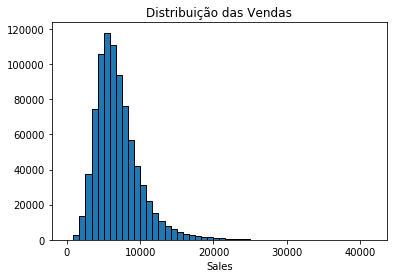

In [24]:
# Histograma da Variavel 'Sales'
plt.hist(dataset_treino['Sales'], bins = 50, edgecolor = 'k');
plt.xlabel('Sales');  
plt.title('Distribuição das Vendas');

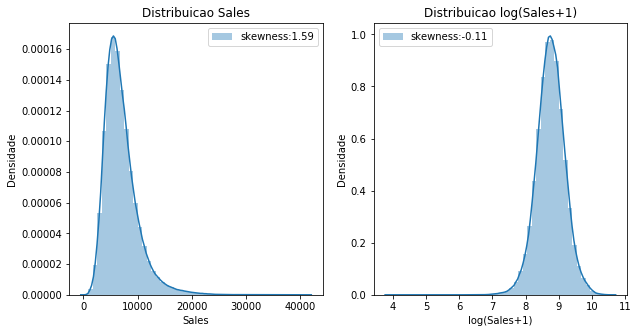

In [25]:
# Comparacao do Histograma da Variavel 'Sales'
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
graf1 = sns.distplot(dataset_treino['Sales'], hist = True, label='skewness:{:.2f}'.format(dataset_treino['Sales'].skew()),ax = ax1)
graf1.legend()
graf1.set(xlabel = 'Sales', ylabel = 'Densidade', title = 'Distribuicao Sales')
graf2 = sns.distplot(np.log1p(dataset_treino['Sales']), hist = True, label = 'skewness:{:.2f}'.format(np.log1p(dataset_treino['Sales']).skew()),ax=ax2)
graf2.legend()
graf2.set(xlabel = 'log(Sales+1)',ylabel = 'Densidade', title = 'Distribuicao log(Sales+1)')
plt.show()

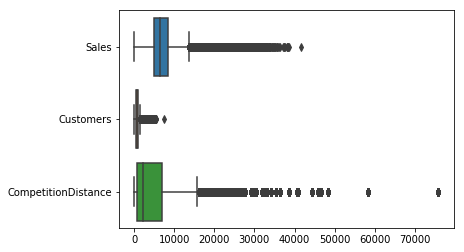

In [26]:
# Boxplot
variaveis_num = ['Sales', 'Customers', 'CompetitionDistance']
sns.boxplot(data = dataset_treino[variaveis_num], orient = "h")
plt.show()

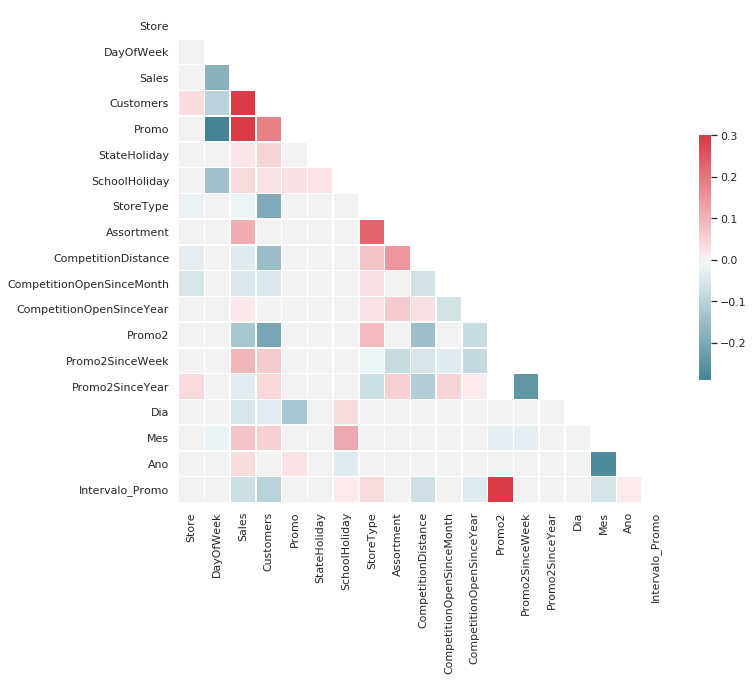

In [27]:
# Gráfico de Correlação
sns.set(style = "white")

# Compute the correlation matrix
corr = dataset_treino.corr(method = 'pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
            square = True, linewidths = .5, cbar_kws={"shrink": .5})

plt.show()

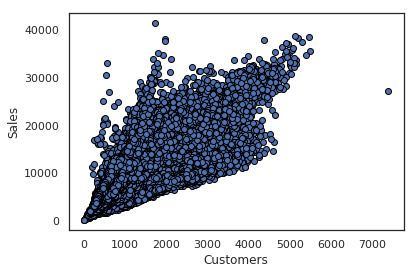

In [28]:
# Grafico dos Customers x Sales
fig, ax = plt.subplots()
ax.scatter(dataset_treino['Customers'], dataset_treino['Sales'], edgecolors = (0, 0, 0))
ax.set_xlabel('Customers')
ax.set_ylabel('Sales')
plt.show()

### Imputação de Dados Faltantes

In [29]:
# Imputando os Dados Faltantes da variavel CompetitionDistance
mediana = dataset_treino['CompetitionDistance'].median()
d = {np.nan: mediana}
dataset_treino['CompetitionDistance'] = dataset_treino['CompetitionDistance'].replace(d)

dataset_teste['CompetitionDistance'] = dataset_teste['CompetitionDistance'].replace(d)

In [30]:
# Mudando os Na para 0
d = {np.nan: '0'}
dataset_treino['CompetitionOpenSinceMonth'] = dataset_treino['CompetitionOpenSinceMonth'].replace(d)
dataset_treino['CompetitionOpenSinceYear'] = dataset_treino['CompetitionOpenSinceYear'].replace(d)

dataset_teste['CompetitionOpenSinceMonth'] = dataset_teste['CompetitionOpenSinceMonth'].replace(d)
dataset_teste['CompetitionOpenSinceYear'] = dataset_teste['CompetitionOpenSinceYear'].replace(d)

dataset_treino['Promo2SinceWeek'] = dataset_treino['Promo2SinceWeek'].replace(d)
dataset_treino['Promo2SinceYear'] = dataset_treino['Promo2SinceYear'].replace(d)

dataset_teste['Promo2SinceWeek'] = dataset_teste['Promo2SinceWeek'].replace(d)
dataset_teste['Promo2SinceYear'] = dataset_teste['Promo2SinceYear'].replace(d)

### One Hot Encoding

In [31]:
# Transformando os resultados em arrays
valores_storetype = np.array(dataset_treino['StoreType'])
valores_assortment = np.array(dataset_treino['Assortment'])
valores_state = np.array(dataset_treino['StateHoliday'])

valores_storetype_teste = np.array(dataset_teste['StoreType'])
valores_assortment_teste = np.array(dataset_teste['Assortment'])
valores_state_teste = np.array(dataset_teste['StateHoliday'])

In [32]:
# Reshape nos dados
inteiros_storetype = valores_storetype.reshape(len(valores_storetype),1)
inteiros_assortment = valores_assortment.reshape(len(valores_assortment),1)
inteiros_state = valores_state.reshape(len(valores_state),1)

inteiros_storetype_teste = valores_storetype_teste.reshape(len(valores_storetype_teste),1)
inteiros_assortment_teste = valores_assortment_teste.reshape(len(valores_assortment_teste),1)
inteiros_state_teste = valores_state_teste.reshape(len(valores_state_teste),1)

In [33]:
# Criando um objeto do tipo 'OneHotEnconder'
onehot_encoder1 = OneHotEncoder(sparse = False).fit(inteiros_storetype)
onehot_encoder2 = OneHotEncoder(sparse = False).fit(inteiros_assortment)
onehot_encoder3 = OneHotEncoder(sparse = False).fit(inteiros_state)

# Transformação nos dados de treino
vetores_binarios1 = onehot_encoder1.transform(inteiros_storetype)
vetores_binarios2 = onehot_encoder2.transform(inteiros_assortment)
vetores_binarios3 = onehot_encoder3.transform(inteiros_state)

# Transformação nos dados de teste
vetores_binarios1_teste = onehot_encoder1.transform(inteiros_storetype_teste)
vetores_binarios2_teste = onehot_encoder2.transform(inteiros_assortment_teste)
vetores_binarios3_teste = onehot_encoder3.transform(inteiros_state_teste)

In [34]:
# Concatenando os resultados
vetores_binarios = pd.concat([pd.DataFrame(vetores_binarios1, 
                                           columns = ['store0', 'store1', 'store2', 'store3']), 
                              pd.DataFrame(vetores_binarios2, 
                                           columns = ['assort0', 'assort1', 'assort2']), 
                              pd.DataFrame(vetores_binarios3, 
                                           columns = ['state0', 'state1', 'state2', 'state3'])], 
                             axis = 1)

vetores_binarios_teste = pd.concat([pd.DataFrame(vetores_binarios1_teste, 
                                                 columns = ['store0', 'store1', 'store2', 'store3']), 
                                  pd.DataFrame(vetores_binarios2_teste, 
                                               columns = ['assort0', 'assort1', 'assort2']), 
                                  pd.DataFrame(vetores_binarios3_teste, 
                                               columns = ['state0', 'state1', 'state2', 'state3'])], 
                                   axis = 1)

vetores_binarios.head(5)

,store0,store1,store2,store3,assort0,assort1,assort2,state0,state1,state2,state3
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [35]:
# Alinhando os indices
vetores_binarios.index = dataset_treino.index

vetores_binarios_teste.index = dataset_teste.index

### Feature Selection

In [36]:
# Importância do Atributo com o Extra Trees Regressor

# Separando o array em componentes de input e output
colunas_choice =   ['Promo', 'Store', 'Mes', 'Ano', 'Dia', 'DayOfWeek', 
                    'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth',
                    'SchoolHoliday',  'CompetitionDistance', 
                    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Intervalo_Promo', 'Sales']

#StoreTypeAssortmentStateHoliday
df = dataset_treino[colunas_choice]
array = df.values

# Separando o array em componentes de input e output
X = array[:,0:(len(colunas_choice)-1)]
Y = array[:,(len(colunas_choice)-1)]

# Criação do Modelo - Feature Selection
modelo = ExtraTreesRegressor()
modelo.fit(X, Y)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

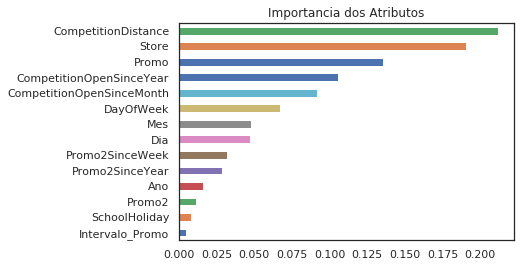

In [37]:
# Plotando as variaveis mais importantes
feat_importances = pd.Series(modelo.feature_importances_, index = colunas_choice[:-1])
feat_importances.sort_values(ascending = True).plot(kind = 'barh')
plt.title('Importancia dos Atributos')
plt.show()

In [38]:
# Juntando os resultados de transformacao dos dados 
colunas_importance = ['CompetitionDistance', 'Store',  'Promo', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth',
                      'DayOfWeek', 'Mes', 'Dia', 'Promo2SinceWeek', 'Promo2SinceYear', 'Ano']
data_modelo = dataset_treino[colunas_importance].copy()
data_modelo = data_modelo.join(vetores_binarios)

data_modelo_teste = dataset_teste[colunas_importance].copy()
data_modelo_teste = data_modelo_teste.join(vetores_binarios_teste)

In [39]:
# Separando em X e Y
X_treino = data_modelo.values
Y_treino = dataset_treino['Sales']

### Criação do Modelo

In [40]:
#def rmspe(predictions, targets):
#    return np.sqrt((((targets - predictions)/targets) ** 2).mean())

In [41]:
# Criando modelo de Machine Learning a partir de cada algoritmo

#modelos = []
#modelos.append(('LR', LinearRegression()))
#modelos.append(('LASSO', Lasso()))
#modelos.append(('EN', ElasticNet()))
#modelos.append(('Ridge', Ridge()))
#modelos.append(('KNN', KNeighborsRegressor()))
#modelos.append(('CART', DecisionTreeRegressor()))
#modelos.append(('SVR', SVR(gamma = 'auto')))
#modelos.append(('AB', AdaBoostRegressor(n_estimators = 100)))
#modelos.append(('GBM', GradientBoostingRegressor(n_estimators = 100)))
#modelos.append(('RF', RandomForestRegressor(n_estimators = 100)))
#modelos.append(('ET', ExtraTreesRegressor(n_estimators = 100)))
#modelos.append(('XG', XGBRegressor()))

#resultados = []
#nomes = []

# Percorrendo cada um dos modelos
#for nome, modelo in modelos:
#    kfold = model_selection.KFold(10, True, random_state = 42)
#    previsoes = cross_val_predict(modelo, X_treino, np.log1p(Y_treino), cv = kfold)
#    metrica = rmspe(np.expm1(previsoes), np.expm1(Y_treino))
#    resultados.append(previsoes)
#    nomes.append(nome)
#    texto = "%s: %f" % (nome, metrica)
#    print(texto)
# 0.18079538227473296
# 0.17492211856266057

In [42]:
# Graficos das previsoes
#fig, ax = plt.subplots()
#ax.scatter(np.expm1(Y_treino), np.expm1(previsoes), edgecolors = (0, 0, 0))
#ax.plot([Y_treino.min(), Y_treino.max()], [Y_treino.min(), Y_treino.max()], 'k--', lw = 4)
#ax.set_xlabel('Observado')
#ax.set_ylabel('Previsto')
#plt.show()

### Otimização do XGBoost

In [43]:
# Funcoes para calculo do RMPSE

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xgboost(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [44]:
# Melhores parametros
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.1,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.5,
          "silent": 1,
          "seed": 42
          }
num_boost_round = 2500

# Treinando um modelo XGBoost
X_train, X_valid, y_train, y_valid = train_test_split(X_treino, Y_treino, test_size = 0.015, random_state = 42)

dtrain = xgb.DMatrix(X_train, np.log1p(y_train)) # dados de treino
dvalid = xgb.DMatrix(X_valid, np.log1p(y_valid)) # dados de validacao

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

modelo = xgb.train(params, dtrain, num_boost_round, evals = watchlist, \
  early_stopping_rounds = 100, feval = rmspe_xgboost, verbose_eval = True)

[0]	train-rmse:7.44372	eval-rmse:7.43937	train-rmspe:0.999526	eval-rmspe:0.999523
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:6.70137	eval-rmse:6.69743	train-rmspe:0.998818	eval-rmspe:0.998812
[2]	train-rmse:6.03302	eval-rmse:6.02933	train-rmspe:0.997544	eval-rmspe:0.997532
[3]	train-rmse:5.43193	eval-rmse:5.42842	train-rmspe:0.995393	eval-rmspe:0.995372
[4]	train-rmse:4.89124	eval-rmse:4.88799	train-rmspe:0.991974	eval-rmspe:0.99194
[5]	train-rmse:4.40441	eval-rmse:4.40162	train-rmspe:0.986885	eval-rmspe:0.986836
[6]	train-rmse:3.96663	eval-rmse:3.96386	train-rmspe:0.979634	eval-rmspe:0.979557
[7]	train-rmse:3.57258	eval-rmse:3.5702	train-rmspe:0.969828	eval-rmspe:0.969725
[8]	train-rmse:3.21837	eval-rmse:3.21633	train-rmspe:0.957007	eval-rmspe:0.956873
[9]	train-rmse:2.89989	eval-rmse:2.89809	train-rmspe:0.940917	eval-rmspe:0.940742
[10]	train-rmse:2.61335	eval-rmse:2.

In [45]:
# Resultado nos dados de validacao
y_pred = modelo.predict(xgb.DMatrix(X_valid), ntree_limit = modelo.best_ntree_limit)
erro = rmspe(y_valid.values, np.expm1(y_pred))
print(' O RMSPE é : {:.5f}'.format(erro))

 O RMSPE é : 0.10817


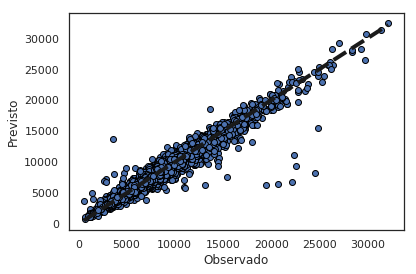

In [46]:
# Graficos das previsoes
fig, ax = plt.subplots()
ax.scatter(y_valid.values, np.expm1(y_pred), edgecolors = (0, 0, 0))
ax.plot([y_valid.values.min(), y_valid.values.max()], [y_valid.values.min(), y_valid.values.max()], 'k--', lw = 4)
ax.set_xlabel('Observado')
ax.set_ylabel('Previsto')
plt.show()

### Previsão

In [47]:
# Prevendo para os dados em que a loja foi aberta
dtest = xgb.DMatrix(data_modelo_teste.values)
previsoes_teste = np.expm1(modelo.predict(dtest, ntree_limit = modelo.best_ntree_limit))

In [48]:
# Juntando os resultados das previsoes
Submissao = pd.DataFrame(dataset_teste['Id'])
Submissao['Sales'] = previsoes_teste

In [49]:
# Adicionando a variavel Sales com valores zeros para lojas que não abriram
sep_teste_notopen['Sales'] = 0
Submissao2 = sep_teste_notopen[['Id','Sales']]

In [50]:
# Juntando os dataframes
Submissao_final = pd.concat([Submissao, Submissao2])
Submissao_final.head(10)

,Id,Sales
0,1,3848.884277
1,857,4229.848145
2,1713,4484.159180
3,2569,4875.898438
5,4281,4020.874268
6,5137,3423.824219
7,5993,3282.628906
8,6849,3476.669189
9,7705,3434.104980
10,8561,3925.085938


In [51]:
# Ordenando os dados de submissao
Submissao_final = Submissao_final.sort_values(by = ['Id'])

In [52]:
# Salvando os resultados
Submissao_final.to_csv('Submission.csv', header = True, index = False)